# Modélisation de la Valeur Assurée des Navires
## Analyse et Prédiction Machine Learning

Ce notebook contient l'analyse complète des données navires, du nettoyage des données à la prédiction avec machine learning.

## Étape 1 : Importation des Bibliothèques Requises
Nous importons tous les outils nécessaires pour l'analyse et la modélisation.

In [34]:
# Import des bibliothèques essentielles
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay

# Configuration pour les visualisations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('✅ Toutes les bibliothèques ont été importées avec succès!')

✅ Toutes les bibliothèques ont été importées avec succès!


## Étape 2 : Chargement des Données
Charge le fichier CSV avec le bon séparateur et affiche un aperçu des données.

In [35]:
# Chargement du fichier CSV avec le bon séparateur
df = pd.read_csv('data_navire.csv', sep=';')

# Nettoyage des noms de colonnes (enlever les espaces)
df.columns = df.columns.str.strip()

# Affichage des informations de base
print(f"Nombre de lignes : {df.shape[0]}")
print(f"Nombre de colonnes : {df.shape[1]}")
print(f"\nNoms des colonnes : {df.columns.tolist()}")
print(f"\nPremières lignes du dataset:")
df.head(10)

Nombre de lignes : 88
Nombre de colonnes : 11

Noms des colonnes : ['IMO', 'TYPE', 'BUILT', 'GRT', 'DWT', 'Engine power', 'Builder', 'CLASS', 'CAT CLASS', 'FLAG', 'INSURED VALUE']

Premières lignes du dataset:


,IMO,TYPE,BUILT,GRT,DWT,Engine power,Builder,CLASS,CAT CLASS,FLAG,INSURED VALUE
0,9962524,UCC,2023,9587,11817,6900,JAPAN,NKK,IACS,PANAMA,18400000
1,9961544,UCC,2023,9562,11817,6900,JAPAN,LR,IACS,PANAMA,18400000
2,9961271,UCC,2022,9587,11793,6900,JAPAN,NKK,IACS,PANAMA,18400000
3,9650066,UCC,2013,20920,23927,14280,SOUTH KOREA,KR,IACS,MSH,15200000
4,9449857,UCC,2009,17068,21191,15227,CHINA,ABS,IACS,PANAMA,10400000
5,9396634,Container ship,2008,16162,17350,12540,CHINA,ABS,IACS,PANAMA,13500000
6,9309150,Container ship,2005,18327,23395,15820,CHINA,NKK,IACS,Malta,10400000
7,9133599,Oil Tanker,1995,4025,4450,2600,États-Unis,MACOSNAR,NON IACS,PANAMA,1?700?000
8,9297101,Oil Tanker,2004,4064,4531,2690,CHINA,BV,IACS,PANAMA,3?820?000
9,9125346,Oil Tanker,1995,4063,4685,2588,JAPAN,MACOSNAR,NON IACS,PANAMA,2?000?000


## Étape 3 : Analyse Préliminaire des Données
Examinez les types de données et les valeurs manquantes.

In [36]:
# Affichage détaillé des informations du DataFrame
print("Information détaillée sur le DataFrame:")
print(df.info())
print("\nAperçu statistique:")
print(df.describe())
print("\nValeurs manquantes:")
print(df.isnull().sum())

Information détaillée sur le DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   IMO            88 non-null     int64 
 1   TYPE           88 non-null     object
 2   BUILT          88 non-null     int64 
 3   GRT            88 non-null     int64 
 4   DWT            88 non-null     int64 
 5   Engine power   88 non-null     int64 
 6   Builder        88 non-null     object
 7   CLASS          88 non-null     object
 8   CAT CLASS      88 non-null     object
 9   FLAG           88 non-null     object
 10  INSURED VALUE  88 non-null     object
dtypes: int64(5), object(6)
memory usage: 7.7+ KB
None

Aperçu statistique:
                IMO        BUILT           GRT            DWT  Engine power
count  8.800000e+01    88.000000     88.000000      88.000000     88.000000
mean   8.982545e+06  2009.352273  17015.693182   27852.215909   6365.8

## Étape 4 : Nettoyage de la Colonne Cible (INSURED VALUE)
Convertissez la colonne de valeur assurée en format numérique.

In [37]:
# Nettoyage de la colonne INSURED VALUE
# Étape 1: Convertir en chaîne et enlever les caractères non numériques
df['INSURED VALUE'] = df['INSURED VALUE'].astype(str).str.replace(r'[^\d.]', '', regex=True)

# Étape 2: Convertir en numérique
df['INSURED VALUE'] = pd.to_numeric(df['INSURED VALUE'], errors='coerce')

# Étape 3: Vérification
print("Type de données INSURED VALUE:", df['INSURED VALUE'].dtype)
print("\nAperçu après nettoyage:")
print(df[['INSURED VALUE']].head(10))
print(f"\nValeurs manquantes: {df['INSURED VALUE'].isnull().sum()}")

Type de données INSURED VALUE: int64

Aperçu après nettoyage:
   INSURED VALUE
0       18400000
1       18400000
2       18400000
3       15200000
4       10400000
5       13500000
6       10400000
7        1700000
8        3820000
9        2000000

Valeurs manquantes: 0


## Étape 5 : Création de Nouvelles Variables
Créez des variables supplémentaires utiles pour le modèle.

In [38]:
# Création de la variable AGE des navires
df['AGE'] = 2026 - df['BUILT']
print(f"Age minimum: {df['AGE'].min()} ans")
print(f"Age maximum: {df['AGE'].max()} ans")
print(f"Age moyen: {df['AGE'].mean():.1f} ans")

# Nettoyage des variables catégorielles (TYPE)
df['TYPE'] = df['TYPE'].str.upper().str.strip()
print(f"\nTypes de navires uniques avant fusionement:")
print(df['TYPE'].value_counts())

Age minimum: 1 ans
Age maximum: 46 ans
Age moyen: 16.6 ans

Types de navires uniques avant fusionement:
TYPE
OIL TANKER                38
LPG                       18
BBU                       13
BULK CARRIER               6
UCC                        5
OFFSHORE SUPPLY VESSEL     3
CONTAINER SHIP             2
MPP BULK                   1
DREDGER                    1
GENERAL CARGO SHIP         1
Name: count, dtype: int64


## Étape 6 : Fusion des Catégories Similaires
Unifiez les types de navires pour homogénéiser les données.

In [39]:
# Création du dictionnaire de remplacement pour fusionner les synonymes
mappage = {
    'TANKER': 'OIL TANKER',
    'OIL PRODUCTS TANKER': 'OIL TANKER',
    'OIL PRODUCTS TAN': 'OIL TANKER',
    'OFFSHORE SUPPI': 'OFFSHORE SUPPLY',
    'OFFSHORE SUPPL': 'OFFSHORE SUPPLY',
    'MPP BULK': 'BULK CARRIER',
    'BBU': 'BULK CARRIER',
    'GENERAL CARGO SH': 'GENERAL CARGO',
    'GENERAL CARGO VESSEL': 'GENERAL CARGO',
    'CONTAINER SHIP': 'CONTAINER',
    'CONTAINER VESSEL': 'CONTAINER',
    'UCC': 'CONTAINER',
    'dredge': 'DREDGER',
    'lpg tanker': 'LPG TANKER',
    'lpg': 'LPG TANKER',
}

# Application du remplacement
df['TYPE'] = df['TYPE'].replace(mappage)

# Vérification : Afficher le nombre de navires par catégorie nettoyée
print("Catégories unifiées après fusion:")
print(df['TYPE'].value_counts())

Catégories unifiées après fusion:
TYPE
OIL TANKER                38
BULK CARRIER              20
LPG                       18
CONTAINER                  7
OFFSHORE SUPPLY VESSEL     3
GENERAL CARGO SHIP         1
DREDGER                    1
Name: count, dtype: int64


## Étape 7 : Encodage des Variables Catégorielles
Transformez le texte en nombres pour l'entraînement du modèle.

In [40]:
# Encodage du TYPE de navire
le = LabelEncoder()
df['TYPE_ENCODED'] = le.fit_transform(df['TYPE'])

# Affichage du mapping entre types et codes
print("Mapping des types de navires:")
for index, class_label in enumerate(le.classes_):
    count = (df['TYPE'] == class_label).sum()
    print(f"  {index}: {class_label} ({count} navires)")

print(f"\nAperçu de l'encodage:")
print(df[['TYPE', 'TYPE_ENCODED']].head(10))

Mapping des types de navires:
  0: BULK CARRIER (20 navires)
  1: CONTAINER (7 navires)
  2: DREDGER (1 navires)
  3: GENERAL CARGO SHIP (1 navires)
  4: LPG (18 navires)
  5: OFFSHORE SUPPLY VESSEL (3 navires)
  6: OIL TANKER (38 navires)

Aperçu de l'encodage:
         TYPE  TYPE_ENCODED
0   CONTAINER             1
1   CONTAINER             1
2   CONTAINER             1
3   CONTAINER             1
4   CONTAINER             1
5   CONTAINER             1
6   CONTAINER             1
7  OIL TANKER             6
8  OIL TANKER             6
9  OIL TANKER             6


## Étape 8 : Renommage des Colonnes en Français
Renommez les colonnes pour plus de clarté.

In [41]:
# Dictionnaire de traduction des colonnes
traductions = {
    'IMO': 'IMO',
    'TYPE': 'Type_Navire',
    'BUILT': 'Annee_Construction',
    'GRT': 'GRT',
    'DWT': 'DWT',
    'Engine power': 'Puissance_Moteur',
    'Builder': 'Constructeur',
    'CLASS': 'Societe_Classification',
    'FLAG': 'Pavillon',
    'INSURED VALUE': 'Valeur_Assuree'
}

# Application du renommage
df = df.rename(columns=traductions)

# Suppression de la colonne CAT CLASS (redondante)
df = df.drop(columns=['CAT CLASS'])

print("Colonnes renommées:")
print(df.columns.tolist())

Colonnes renommées:
['IMO', 'Type_Navire', 'Annee_Construction', 'GRT', 'DWT', 'Puissance_Moteur', 'Constructeur', 'Societe_Classification', 'Pavillon', 'Valeur_Assuree', 'AGE', 'TYPE_ENCODED']


## Étape 9 : Nettoyage de la Société de Classification
Standardisez et fusionnez les sociétés de classification similaires.

In [42]:
# Liste des membres principaux de l'IACS
iacs_members = ['ABS', 'BV', 'DNV', 'LR', 'NK', 'RINA', 'KR', 'CCS', 'RS', 'CRS', 'PRS']

# Affichage des classes avant nettoyage
print("Sociétés de classification (avant nettoyage):")
print(df['Societe_Classification'].value_counts())

# Nettoyage: mise en majuscules et suppression des espaces
df['Societe_Classification'] = df['Societe_Classification'].astype(str).str.strip().str.upper()

# Fusion des classes similaires
mappage_unification = {
    'NKK': 'NK',
    'CSC': 'CCS',
    'RMRS': 'RS',
    'TURK LLOYD': 'TURKISH LLOYD',
}
df['Societe_Classification'] = df['Societe_Classification'].replace(mappage_unification)

# Vérification après nettoyage
print("\nSociétés après nettoyage:")
print(df['Societe_Classification'].value_counts())

Sociétés de classification (avant nettoyage):
Societe_Classification
NKK           24
DNV           12
CCS           11
ABS            8
BV             7
IRS            4
LR             4
RINA           3
MACOSNAR       3
NK             2
KR             2
NKK            2
BV             2
csc            1
TURK LLOYD     1
LR             1
RMRS           1
Name: count, dtype: int64

Sociétés après nettoyage:
Societe_Classification
NK               28
CCS              12
DNV              12
BV                9
ABS               8
LR                5
IRS               4
RINA              3
MACOSNAR          3
KR                2
TURKISH LLOYD     1
RS                1
Name: count, dtype: int64


## Étape 10 : Création de la Variable IACS
Créez une variable binaire pour identifier les navires classifiés par l'IACS.

In [43]:
# Création d'une colonne binaire pour IACS
df['is_IACS'] = df['Societe_Classification'].isin(iacs_members).astype(int)

# Vérification
print("Distribution de la variable is_IACS:")
print(df['is_IACS'].value_counts())
print(f"\nPourcentage de navires IACS: {(df['is_IACS'].sum() / len(df) * 100):.1f}%")

Distribution de la variable is_IACS:
is_IACS
1    80
0     8
Name: count, dtype: int64

Pourcentage de navires IACS: 90.9%


## Étape 11 : Analyse Statistique par Classe IACS
Analysez les différences de valeur assurée selon la société de classification.

In [44]:
# Filtrer uniquement les navires classifiés par l'IACS
df_iacs = df[df['Societe_Classification'].isin(iacs_members)]

# Calcul des statistiques par société
analyse_classe = df_iacs.groupby('Societe_Classification')['Valeur_Assuree'].agg(
    ['mean', 'median', 'count', 'std']
).sort_values(by='mean', ascending=False)

print("Analyse détaillée des membres IACS:")
print(analyse_classe.to_string())

Analyse détaillée des membres IACS:
                                mean      median  count           std
Societe_Classification                                               
LR                      1.841600e+07  20800000.0      5  1.071752e+07
ABS                     1.391250e+07  13150000.0      8  7.116066e+06
NK                      1.328571e+07  14200000.0     28  3.768654e+06
KR                      1.040000e+07  10400000.0      2  6.788225e+06
DNV                     9.825000e+06   9600000.0     12  5.994865e+06
BV                      7.157500e+06   6000000.0      9  3.922458e+06
CCS                     7.051456e+06   4783150.0     12  4.612667e+06
RS                      4.500000e+06   4500000.0      1           NaN
RINA                    3.142632e+06   2582061.0      3  1.708506e+06


## Étape 12 : Visualisation 1 - Boxplot par Société de Classification
Comparez les valeurs assurées entre les sociétés de classification.

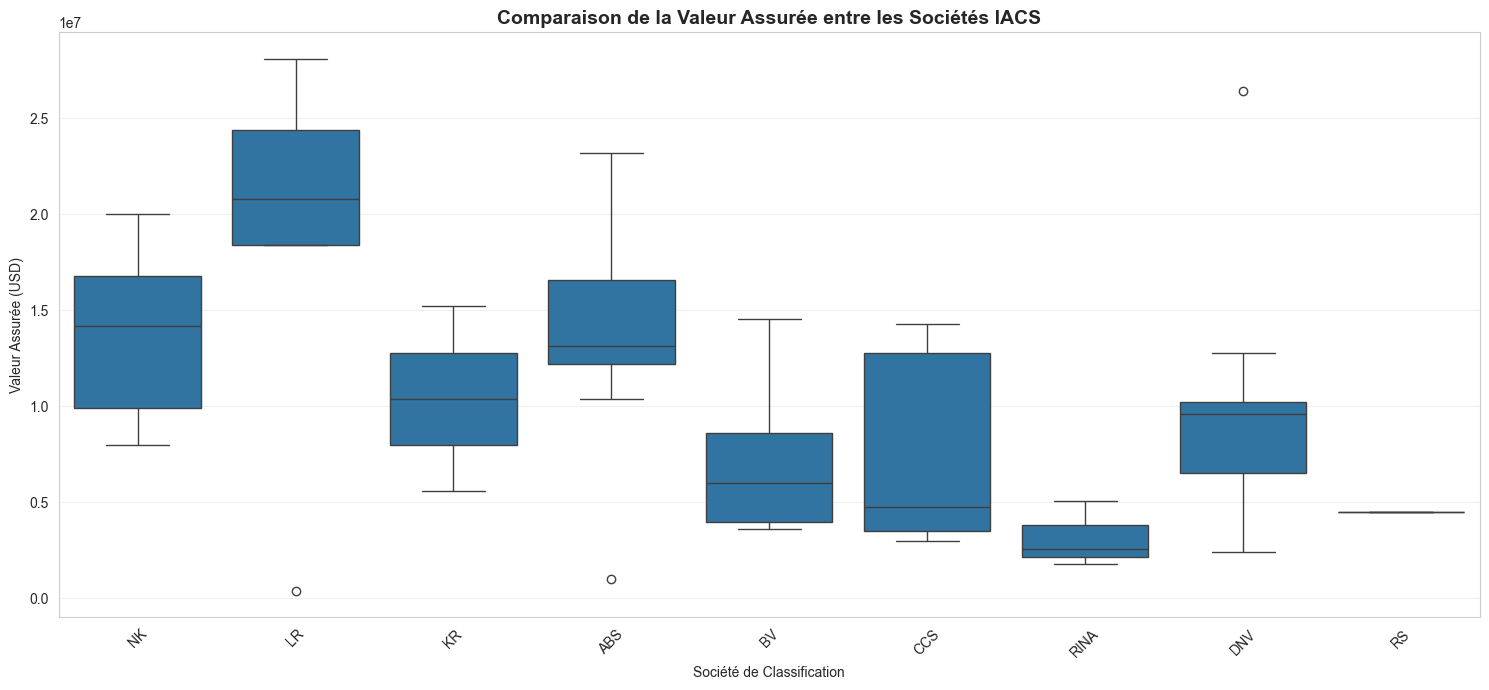

In [45]:
# Visualisation des différences par société de classification
plt.figure(figsize=(15, 7))
sns.boxplot(x='Societe_Classification', y='Valeur_Assuree', data=df_iacs)
plt.xticks(rotation=45)
plt.title('Comparaison de la Valeur Assurée entre les Sociétés IACS', fontsize=14, fontweight='bold')
plt.ylabel('Valeur Assurée (USD)')
plt.xlabel('Société de Classification')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Étape 13 : Visualisation 2 - Boxplot par Type de Navire
Comparez les valeurs assurées entre les types de navires.

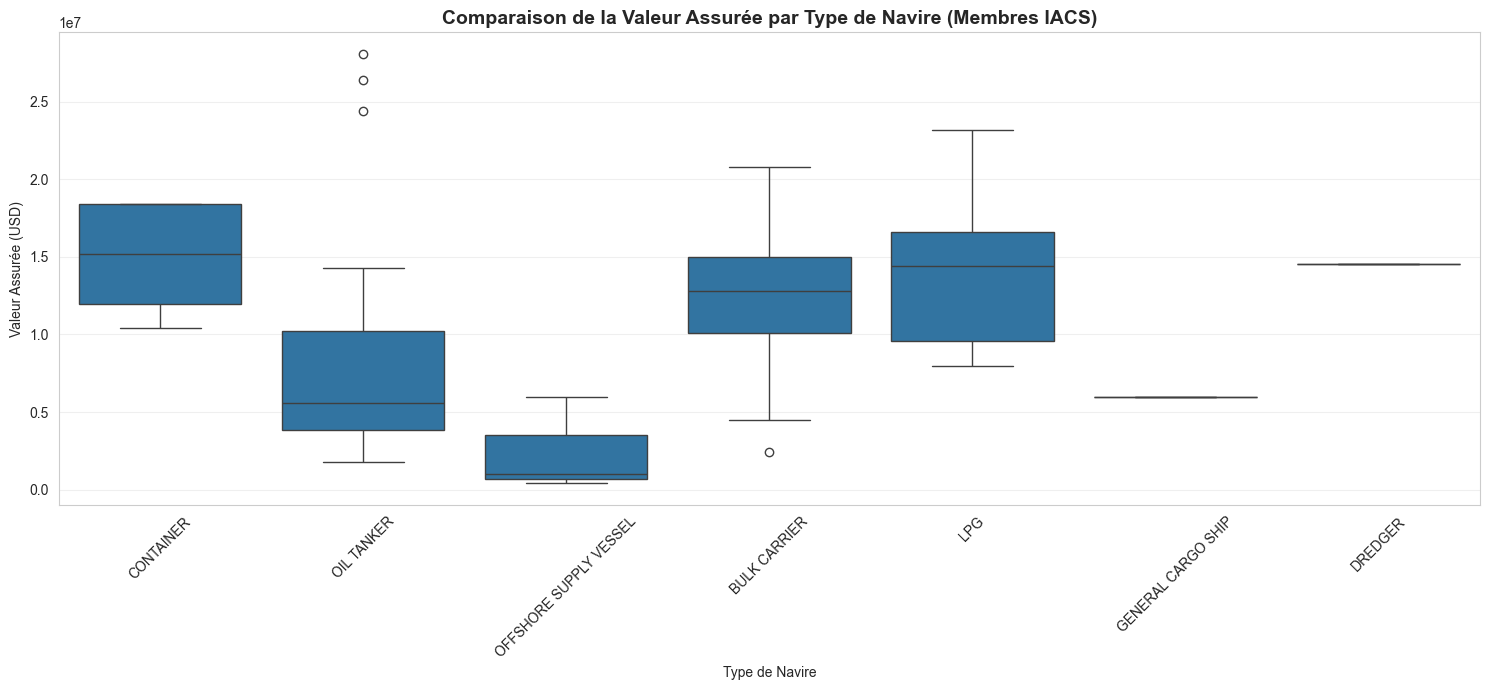

In [46]:
# Visualisation des différences par type de navire
plt.figure(figsize=(15, 7))
sns.boxplot(x='Type_Navire', y='Valeur_Assuree', data=df_iacs)
plt.xticks(rotation=45)
plt.title('Comparaison de la Valeur Assurée par Type de Navire (Membres IACS)', fontsize=14, fontweight='bold')
plt.ylabel('Valeur Assurée (USD)')
plt.xlabel('Type de Navire')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Étape 14 : Visualisation 3 - Relation DWT vs Valeur Assurée
Analysez la relation entre le tonnage et la valeur assurée.

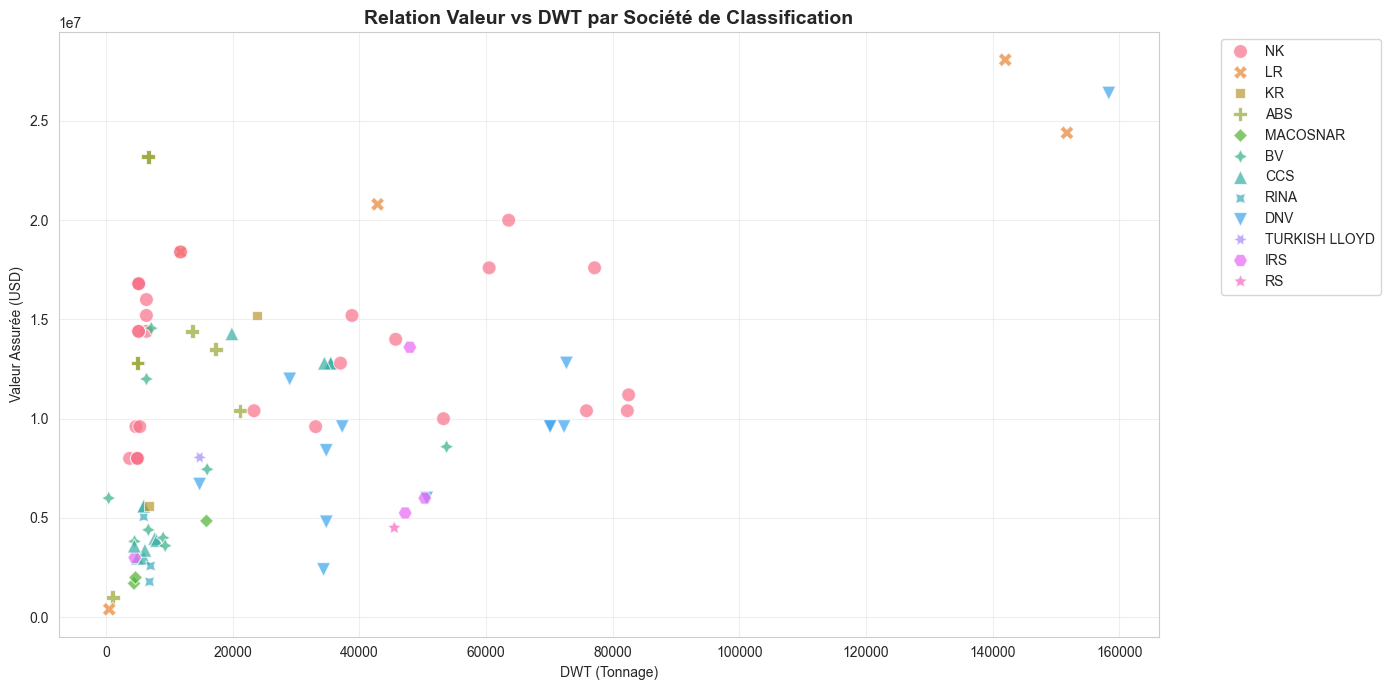

In [47]:
# Visualisation du ratio Valeur/DWT par société de classification
plt.figure(figsize=(14, 7))
sns.scatterplot(
    data=df, 
    x='DWT', 
    y='Valeur_Assuree', 
    hue='Societe_Classification', 
    style='Societe_Classification', 
    s=100,
    alpha=0.7
)
plt.title('Relation Valeur vs DWT par Société de Classification', fontsize=14, fontweight='bold')
plt.xlabel('DWT (Tonnage)')
plt.ylabel('Valeur Assurée (USD)')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Étape 15 : Création du Ratio Valeur/DWT
Créez un ratio pour normaliser la valeur par unité de tonnage.

In [48]:
# Création du ratio valeur par tonne (DWT)
df['Ratio_Valeur_DWT'] = df['Valeur_Assuree'] / df['DWT']

# Statistiques du ratio
print("Statistiques du Ratio Valeur/DWT:")
print(df['Ratio_Valeur_DWT'].describe())

# Aperçu des données
print("\nAperçu:")
print(df[['Valeur_Assuree', 'DWT', 'Ratio_Valeur_DWT']].head(10))

Statistiques du Ratio Valeur/DWT:
count       88.000000
mean      1062.866475
std       1629.238274
min         69.824276
25%        277.153623
50%        487.800134
75%       1557.870990
max      13422.818792
Name: Ratio_Valeur_DWT, dtype: float64

Aperçu:
   Valeur_Assuree    DWT  Ratio_Valeur_DWT
0        18400000  11817       1557.078785
1        18400000  11817       1557.078785
2        18400000  11793       1560.247605
3        15200000  23927        635.265600
4        10400000  21191        490.774385
5        13500000  17350        778.097983
6        10400000  23395        444.539432
7         1700000   4450        382.022472
8         3820000   4531        843.080998
9         2000000   4685        426.894344


## Étape 16 : Visualisation 4 - Identification des Outliers
Visualisez les outliers du ratio Valeur/DWT par type de navire.

C:\Users\samir\AppData\Local\Temp\ipykernel_33292\3452312753.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type_Navire', y='Ratio_Valeur_DWT', data=df, palette='Set3', showfliers=True)


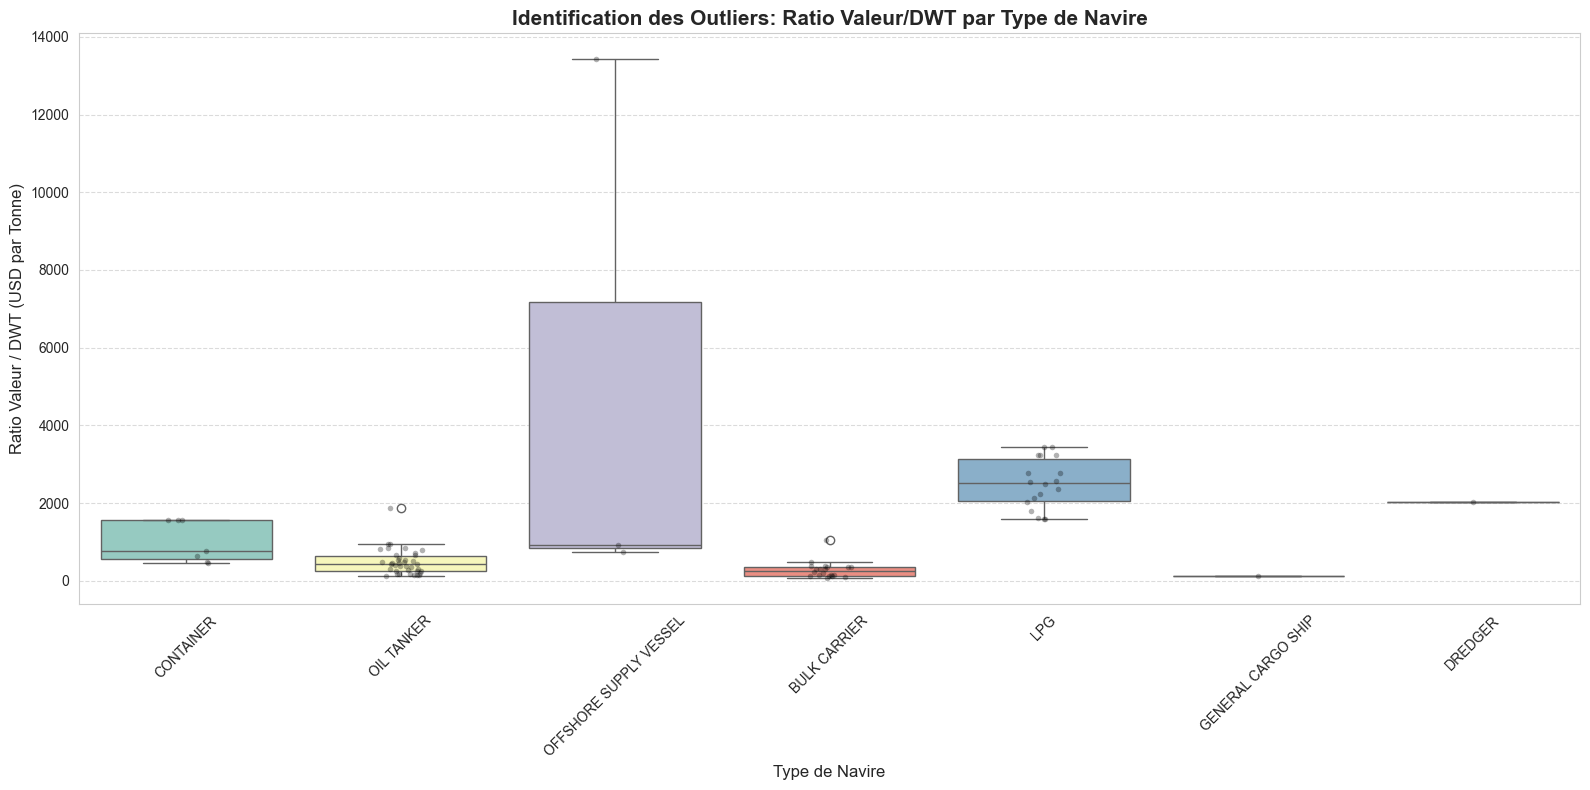

In [49]:
# Visualisation du ratio Valeur/DWT avec identification des outliers
plt.figure(figsize=(16, 8))
sns.boxplot(x='Type_Navire', y='Ratio_Valeur_DWT', data=df, palette='Set3', showfliers=True)
sns.stripplot(x='Type_Navire', y='Ratio_Valeur_DWT', data=df, color='black', size=4, alpha=0.3)
plt.title('Identification des Outliers: Ratio Valeur/DWT par Type de Navire', fontsize=15, fontweight='bold')
plt.xlabel('Type de Navire', fontsize=12)
plt.ylabel('Ratio Valeur / DWT (USD par Tonne)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Étape 17 : Filtrage des Outliers par Groupe
Appliquez la méthode IQR pour supprimer les outliers par type de navire.

In [50]:
# Fonction pour filtrer les outliers par groupe (Type_Navire)
def filter_outliers_by_type(group):
    """Filtre les outliers en utilisant la méthode IQR"""
    Q1 = group['Ratio_Valeur_DWT'].quantile(0.25)
    Q3 = group['Ratio_Valeur_DWT'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Définition des seuils
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Retour du groupe filtré
    return group[(group['Ratio_Valeur_DWT'] >= lower_bound) & (group['Ratio_Valeur_DWT'] <= upper_bound)]

# Application de la fonction à chaque groupe de Type_Navire
df_final = df.groupby('Type_Navire', group_keys=False).apply(filter_outliers_by_type)

# Vérification
print(f"Nombre de navires avant filtrage: {len(df)}")
print(f"Nombre de navires après filtrage IQR: {len(df_final)}")
print(f"Navires supprimés: {len(df) - len(df_final)}")

Nombre de navires avant filtrage: 88
Nombre de navires après filtrage IQR: 86
Navires supprimés: 2


C:\Users\samir\AppData\Local\Temp\ipykernel_33292\1013971515.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_final = df.groupby('Type_Navire', group_keys=False).apply(filter_outliers_by_type)


## Étape 18 : Vérification après Filtrage
Vérifiez que les outliers ont été supprimés correctement.

C:\Users\samir\AppData\Local\Temp\ipykernel_33292\132065600.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type_Navire', y='Ratio_Valeur_DWT', data=df_final, palette='viridis')


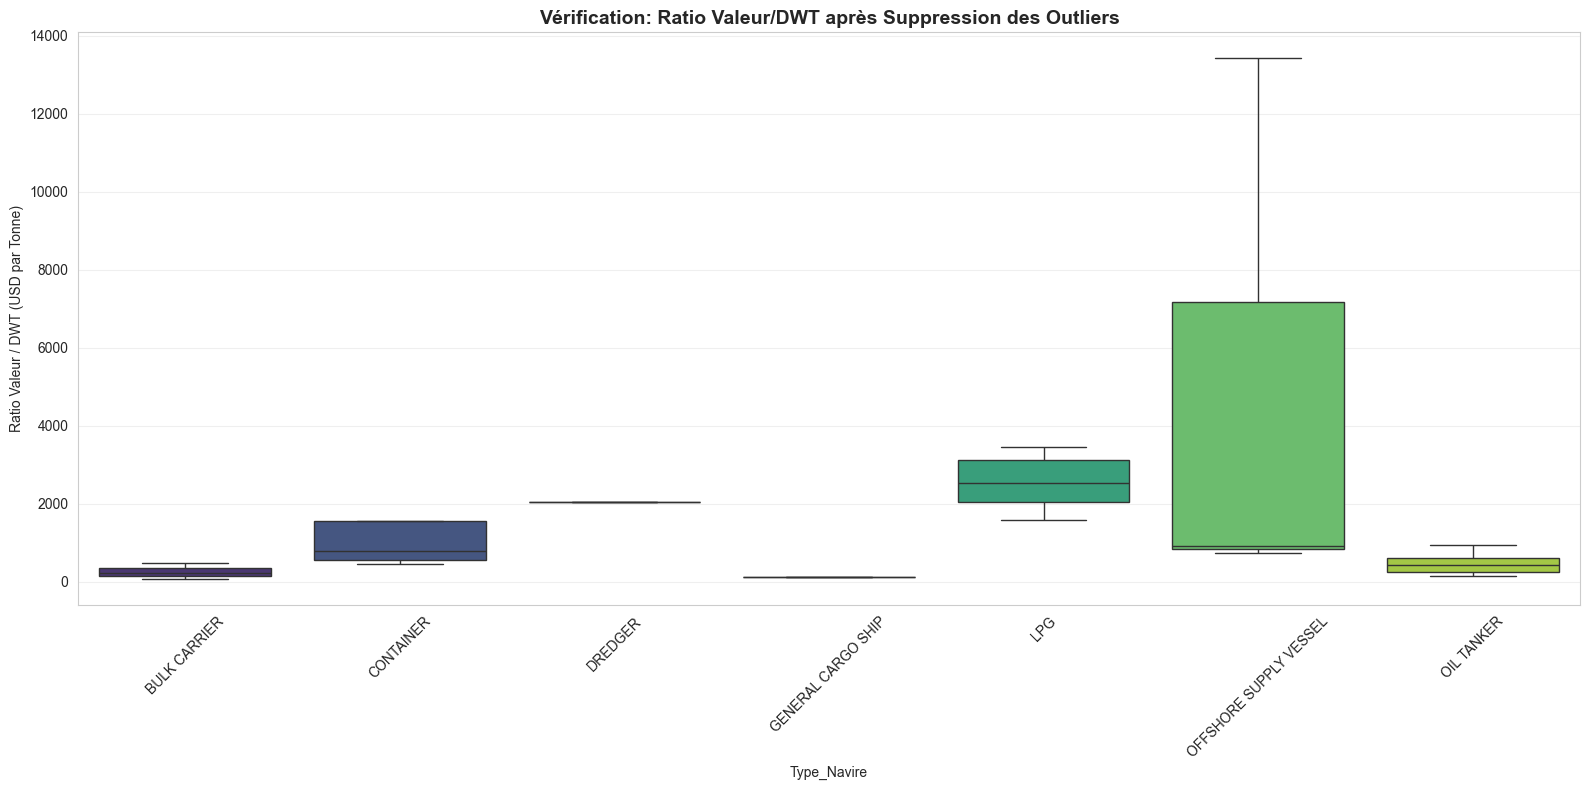

In [51]:
# Visualisation après suppression des outliers
plt.figure(figsize=(16, 8))
sns.boxplot(x='Type_Navire', y='Ratio_Valeur_DWT', data=df_final, palette='viridis')
plt.xticks(rotation=45)
plt.title('Vérification: Ratio Valeur/DWT après Suppression des Outliers', fontsize=14, fontweight='bold')
plt.ylabel('Ratio Valeur / DWT (USD par Tonne)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Étape 19 : Plafonnement Supplémentaire
Appliquez un plafond manuel pour les valeurs extrêmes.

In [52]:
# Application du plafonnement manuel
df_final = df_final[df_final['Ratio_Valeur_DWT'] < 10000]

print(f"Nombre de navires après plafonnement: {len(df_final)}")
print(f"\nStatistiques du Ratio après nettoyage:")
print(df_final['Ratio_Valeur_DWT'].describe())

Nombre de navires après plafonnement: 85

Statistiques du Ratio après nettoyage:
count      85.000000
mean      908.052180
std       947.914684
min        69.824276
25%       258.596784
50%       481.347150
75%      1557.078785
max      3453.408753
Name: Ratio_Valeur_DWT, dtype: float64


## Étape 20 : Nettoyage du Pays de Construction
Standardisez les informations sur le pays de construction.

In [53]:
# Nettoyage et mise en majuscules
df_final['Constructeur'] = df_final['Constructeur'].str.strip().str.upper()

print("Pays de construction (avant correction):")
print(df_final['Constructeur'].unique())

# Correction des pays
df_final['Pays_Construction'] = df_final['Constructeur'].replace({'ÉTATS-UNIS': 'USA'})

print("\nPays après correction:")
print(df_final['Pays_Construction'].value_counts())

Pays de construction (avant correction):
['JAPAN' 'CHINA' 'PHILIPPINES' 'SOUTH KOREA' 'NETHERLANDS' 'ÉTATS-UNIS'
 'TURKEY' 'GERMANY']

Pays après correction:
Pays_Construction
JAPAN          37
CHINA          32
SOUTH KOREA     8
PHILIPPINES     3
NETHERLANDS     2
USA             1
TURKEY          1
GERMANY         1
Name: count, dtype: int64


## Étape 21 : Encodage du Pays de Construction
Convertissez les pays en codes numériques.

In [54]:
# Encodage numérique des pays de construction
le_pays = LabelEncoder()
df_final['PAYS_ENC'] = le_pays.fit_transform(df_final['Pays_Construction'])

# Affichage du mapping
print("Mapping des pays encodés:")
for index, class_label in enumerate(le_pays.classes_):
    count = (df_final['Pays_Construction'] == class_label).sum()
    print(f"  {index}: {class_label} ({count} navires)")

Mapping des pays encodés:
  0: CHINA (32 navires)
  1: GERMANY (1 navires)
  2: JAPAN (37 navires)
  3: NETHERLANDS (2 navires)
  4: PHILIPPINES (3 navires)
  5: SOUTH KOREA (8 navires)
  6: TURKEY (1 navires)
  7: USA (1 navires)


## Étape 22 : Analyse de Corrélation
Calculez la matrice de corrélation sans le pays de construction.

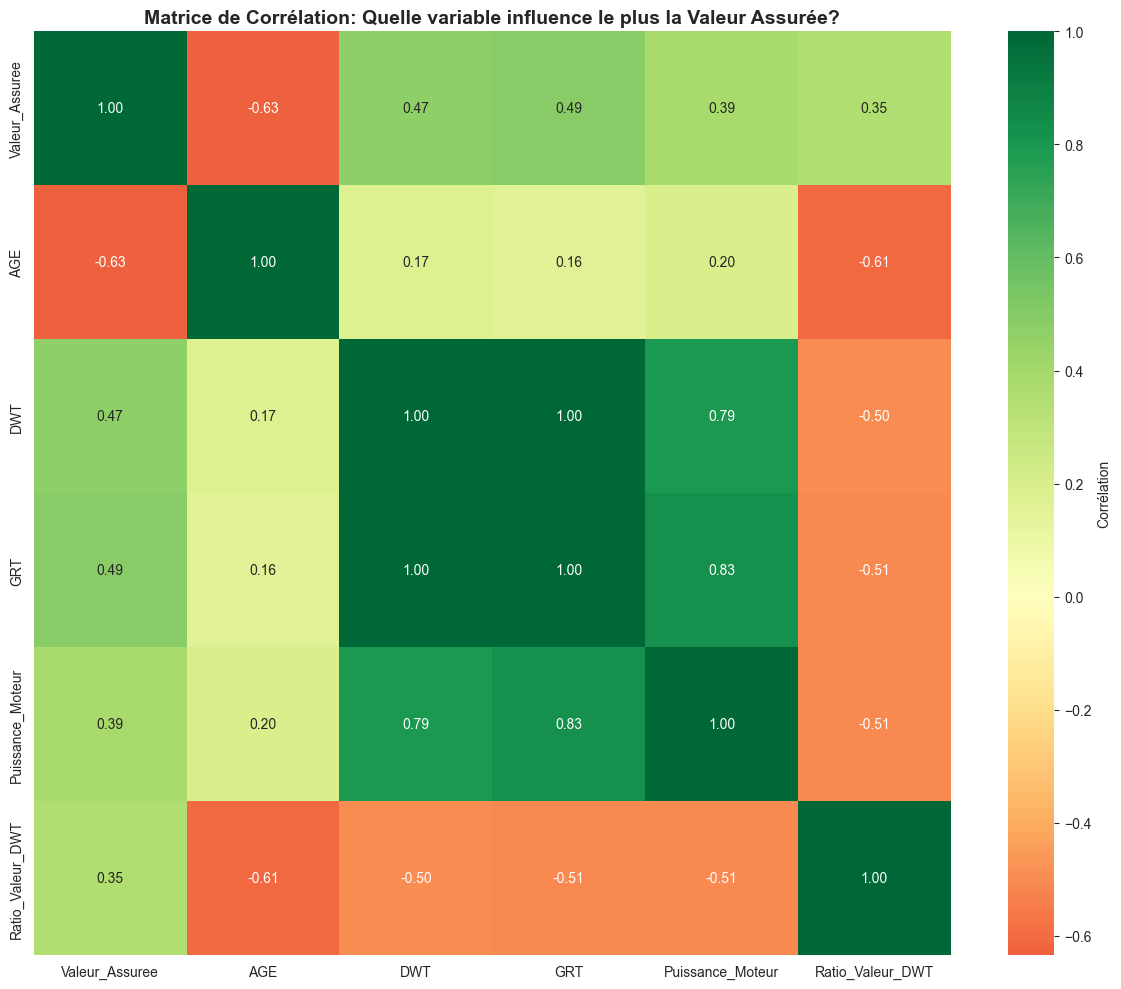

In [55]:
# Sélection des colonnes numériques pertinentes
cols_finales = ['Valeur_Assuree', 'AGE', 'DWT', 'GRT', 'Puissance_Moteur', 'Ratio_Valeur_DWT']

# Calcul de la matrice de corrélation
correlation_matrix = df_final[cols_finales].corr()

# Visualisation
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', cbar_kws={'label': 'Corrélation'})
plt.title('Matrice de Corrélation: Quelle variable influence le plus la Valeur Assurée?', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Étape 23 : Analyse de Corrélation avec le Pays
Calculez la matrice de corrélation avec le pays de construction.

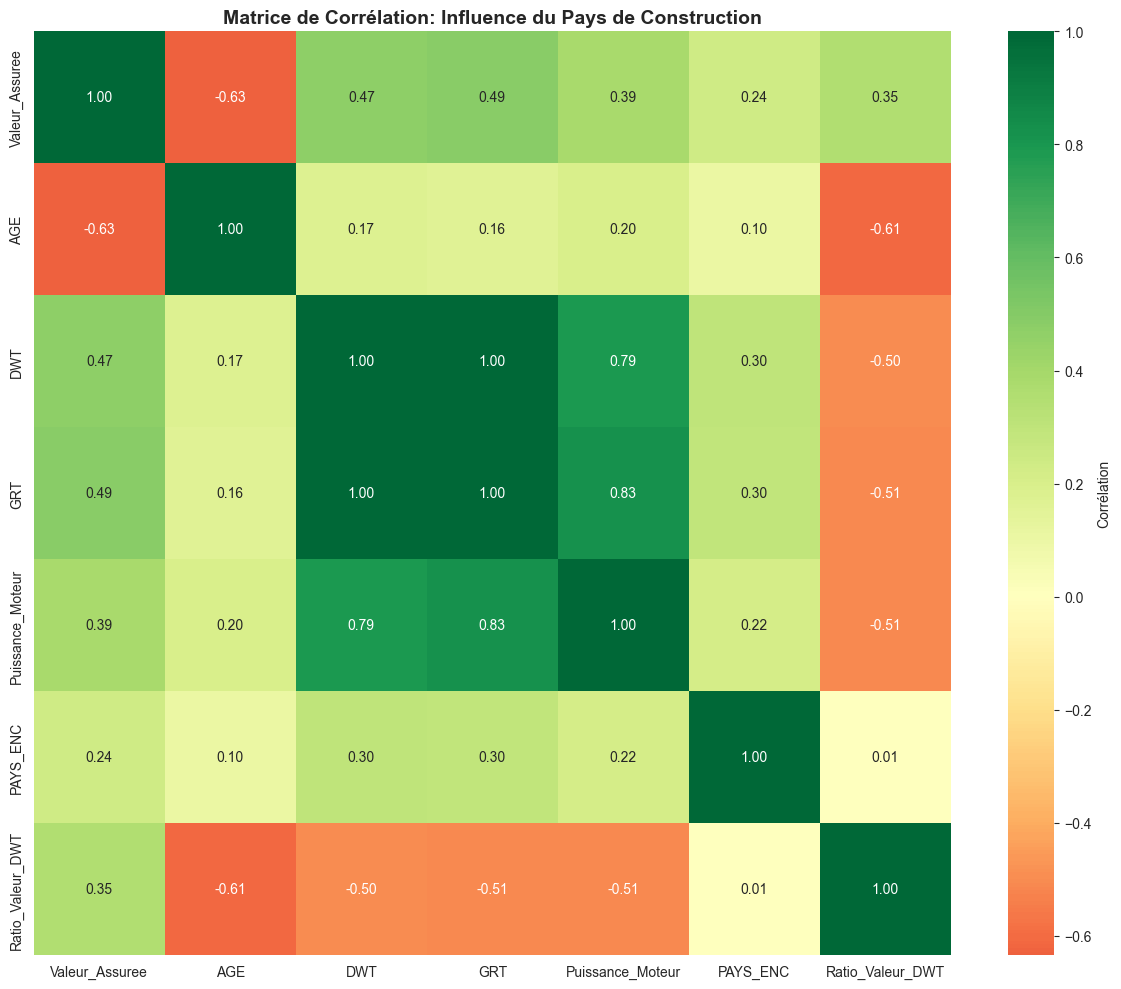

In [56]:
# Sélection des colonnes avec le pays de construction
cols_finales_avec_pays = ['Valeur_Assuree', 'AGE', 'DWT', 'GRT', 'Puissance_Moteur', 'PAYS_ENC', 'Ratio_Valeur_DWT']

# Calcul de la matrice de corrélation
correlation_matrix_pays = df_final[cols_finales_avec_pays].corr()

# Visualisation
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_pays, annot=True, cmap='RdYlGn', center=0, fmt='.2f', cbar_kws={'label': 'Corrélation'})
plt.title('Matrice de Corrélation: Influence du Pays de Construction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Étape 24 : Préparation des Données pour le Modèle
Définissez les features et la cible, puis divisez les données.

In [57]:
# Définition des features (variables d'entrée)
features = ['AGE', 'DWT', 'GRT', 'Puissance_Moteur', 'TYPE_ENCODED', 'is_IACS', 'PAYS_ENC']
X = df_final[features]

# Définition de la cible (variable à prédire)
# Transformation log pour stabiliser la variance
y = np.log1p(df_final['Valeur_Assuree'])

print(f"Nombre d'observations: {len(X)}")
print(f"Nombre de features: {len(features)}")
print(f"\nFeatures utilisées: {features}")
print(f"\nAperçu de X:")
print(X.describe())

Nombre d'observations: 85
Nombre de features: 7

Features utilisées: ['AGE', 'DWT', 'GRT', 'Puissance_Moteur', 'TYPE_ENCODED', 'is_IACS', 'PAYS_ENC']

Aperçu de X:
             AGE            DWT           GRT  Puissance_Moteur  TYPE_ENCODED  \
count  85.000000      85.000000     85.000000         85.000000     85.000000   
mean   17.200000   28593.929412  17440.482353       6479.835294      3.717647   
std     8.273308   33106.706746  17446.348738       4134.351739      2.476613   
min     1.000000     541.000000    806.000000       1765.000000      0.000000   
25%    12.000000    5985.000000   4357.000000       2850.000000      1.000000   
50%    18.000000   11817.000000   9587.000000       6200.000000      4.000000   
75%    23.000000   42902.000000  25955.000000       8600.000000      6.000000   
max    46.000000  158344.000000  81396.000000      18660.000000      6.000000   

         is_IACS   PAYS_ENC  
count  85.000000  85.000000  
mean    0.905882   1.717647  
std     0.293725

## Étape 25 : Division des Données Train/Test
Divisez les données en ensemble d'entraînement et de test.

In [58]:
# Séparation en ensembles d'entraînement (80%) et de test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

print(f"Taille du set d'entraînement: {len(X_train)} observations")
print(f"Taille du set de test: {len(X_test)} observations")
print(f"Ratio train/test: {len(X_train)/len(X_train + X_test)*100:.1f}% / {len(X_test)/len(X_train + X_test)*100:.1f}%")

Taille du set d'entraînement: 68 observations
Taille du set de test: 17 observations
Ratio train/test: 80.0% / 20.0%


## Étape 26 : Entraînement du Modèle XGBoost
Entraînez le modèle XGBoost avec les paramètres optimisés.

In [59]:
# Initialisation et entraînement du modèle XGBoost
model_xgb = xgb.XGBRegressor(
    n_estimators=1000,      # Nombre d'arbres
    learning_rate=0.03,     # Taux d'apprentissage (plus bas = plus stable)
    max_depth=6,            # Profondeur maximale des arbres
    objective='reg:squarederror',  # Fonction de perte
    random_state=42,
    verbosity=0
)

# Entraînement
model_xgb.fit(X_train, y_train)

print('✅ Modèle XGBoost entraîné avec succès!')

✅ Modèle XGBoost entraîné avec succès!


## Étape 27 : Évaluation du Modèle XGBoost
Évaluez les performances du modèle XGBoost.

In [60]:
# Prédictions sur l'échelle Log
y_pred_log = model_xgb.predict(X_test)

# Retour à l'échelle réelle (Dollars)
y_pred_real = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test)

# Calcul des métriques
r2_xgb = r2_score(y_test, y_pred_log)
mae_xgb = mean_absolute_error(y_test_real, y_pred_real)
rmse_xgb = np.sqrt(mean_squared_error(y_test_real, y_pred_real))

# Affichage des résultats
print("="*50)
print("RÉSULTATS DU MODÈLE XGBOOST")
print("="*50)
print(f"Coefficient de Détermination (R²): {r2_xgb:.4f} ({r2_xgb*100:.2f}%)")
print(f"Erreur Absolue Moyenne (MAE): ${mae_xgb:,.2f}")
print(f"Erreur Quadratique Moyenne (RMSE): ${rmse_xgb:,.2f}")
print("="*50)

RÉSULTATS DU MODÈLE XGBOOST
Coefficient de Détermination (R²): 0.7532 (75.32%)
Erreur Absolue Moyenne (MAE): $1,718,669.75
Erreur Quadratique Moyenne (RMSE): $2,548,287.91


## Étape 28 : Tableau de Comparaison des Prédictions
Créez un tableau comparant les valeurs réelles et prédites.

In [61]:
# Création du tableau de comparaison
comparison_df = pd.DataFrame({
    'Valeur_Reelle_USD': y_test_real.values,
    'Valeur_Predite_USD': y_pred_real,
    'Erreur_Absolue_USD': np.abs(y_test_real.values - y_pred_real)
})

# Ajout de l'erreur en pourcentage
comparison_df['Erreur_Pct'] = (comparison_df['Erreur_Absolue_USD'] / comparison_df['Valeur_Reelle_USD']) * 100

# Calcul de la fiabilité globale
fiabilite = 100 - comparison_df['Erreur_Pct'].mean()

print("COMPARAISON DES RÉSULTATS (10 premiers cas):")
print(comparison_df.head(10).to_string())
print(f"\nFiabilité moyenne du modèle: {fiabilite:.2f}%")

COMPARAISON DES RÉSULTATS (10 premiers cas):
   Valeur_Reelle_USD  Valeur_Predite_USD  Erreur_Absolue_USD  Erreur_Pct
0          7450000.0           8367318.5            917318.5   12.313000
1          4500000.0           5260238.0            760238.0   16.894178
2         12000000.0           8832181.0           3167819.0   26.398492
3         15200000.0          12538811.0           2661189.0   17.507822
4         12800000.0          13027338.0            227338.0    1.776078
5         13600000.0           9367110.0           4232890.0   31.124191
6         12800000.0          12801271.0              1271.0    0.009930
7         11200000.0          11439343.0            239343.0    2.136991
8          2400000.0           5178621.5           2778621.5  115.775896
9          4850000.0           5246986.0            396986.0    8.185278

Fiabilité moyenne du modèle: 61.14%


## Étape 29 : Visualisation 5 - Importance des Variables
Affichez l'importance de chaque variable pour le modèle.

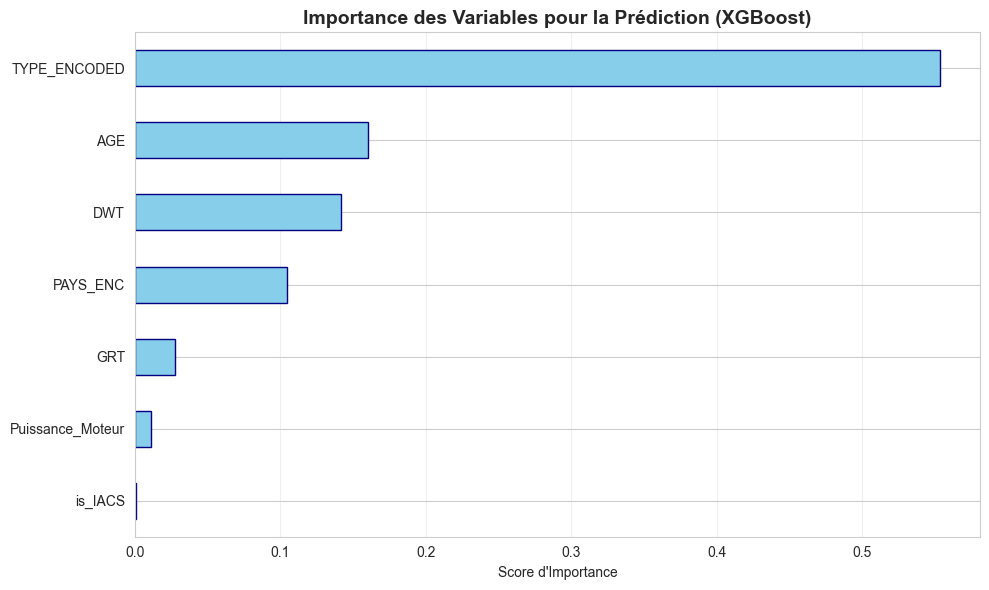


Importance des variables (en %):
TYPE_ENCODED        55.328995
AGE                 16.052534
DWT                 14.203459
PAYS_ENC            10.486951
GRT                  2.755400
Puissance_Moteur     1.100278
is_IACS              0.072381
dtype: float32


In [62]:
# Visualisation de l'importance des variables
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(model_xgb.feature_importances_, index=features)
feat_importances.sort_values(ascending=True).plot(kind='barh', color='skyblue', edgecolor='navy')
plt.title('Importance des Variables pour la Prédiction (XGBoost)', fontsize=14, fontweight='bold')
plt.xlabel('Score d\'Importance')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Affichage en pourcentage
print("\nImportance des variables (en %):")
importance_pct = feat_importances / feat_importances.sum() * 100
print(importance_pct.sort_values(ascending=False))

## Étape 30 : Visualisation 6 - Analyse des Résidus
Vérifiez si le modèle fait des erreurs systématiques.

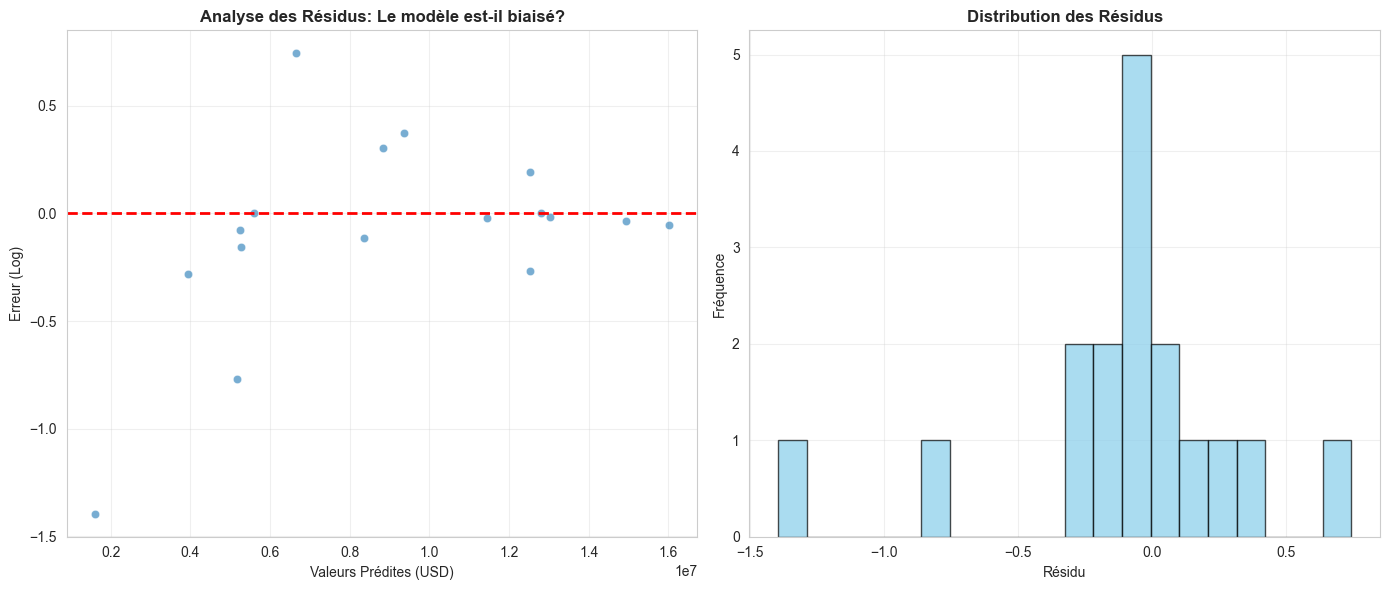

In [63]:
# Calcul des résidus
preds_log = model_xgb.predict(X_test)
residuals = y_test - preds_log

# Visualisation des résidus
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=np.expm1(preds_log), y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title('Analyse des Résidus: Le modèle est-il biaisé?', fontsize=12, fontweight='bold')
plt.xlabel('Valeurs Prédites (USD)')
plt.ylabel('Erreur (Log)')
plt.grid(alpha=0.3)

# Histogramme des résidus
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
plt.title('Distribution des Résidus', fontsize=12, fontweight='bold')
plt.xlabel('Résidu')
plt.ylabel('Fréquence')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Étape 31 : Validation Croisée
Évaluez la stabilité du modèle avec la validation croisée.

In [64]:
# Validation croisée 5-fold
cv_scores = cross_val_score(model_xgb, X, y, cv=5, scoring='r2')

print("VALIDATION CROISÉE (5-fold):")
print("="*50)
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i}: R² = {score:.4f}")
print("="*50)
print(f"Score moyen: {cv_scores.mean():.4f}")
print(f"Écart-type: {cv_scores.std():.4f}")
print(f"Intervalle de confiance (2σ): {cv_scores.mean() - 2*cv_scores.std():.4f} to {cv_scores.mean() + 2*cv_scores.std():.4f}")

VALIDATION CROISÉE (5-fold):
Fold 1: R² = 0.6944
Fold 2: R² = 0.4101
Fold 3: R² = 0.3814
Fold 4: R² = -2.1282
Fold 5: R² = -0.5866
Score moyen: -0.2458
Écart-type: 1.0361
Intervalle de confiance (2σ): -2.3179 to 1.8263


## Étape 32 : Analyse PDP (Partial Dependence Plot)
Visualisez l'impact isolé des variables importantes.

C:\Users\samir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\inspection\_partial_dependence.py:721: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
C:\Users\samir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\inspection\_partial_dependence.py:721: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtype

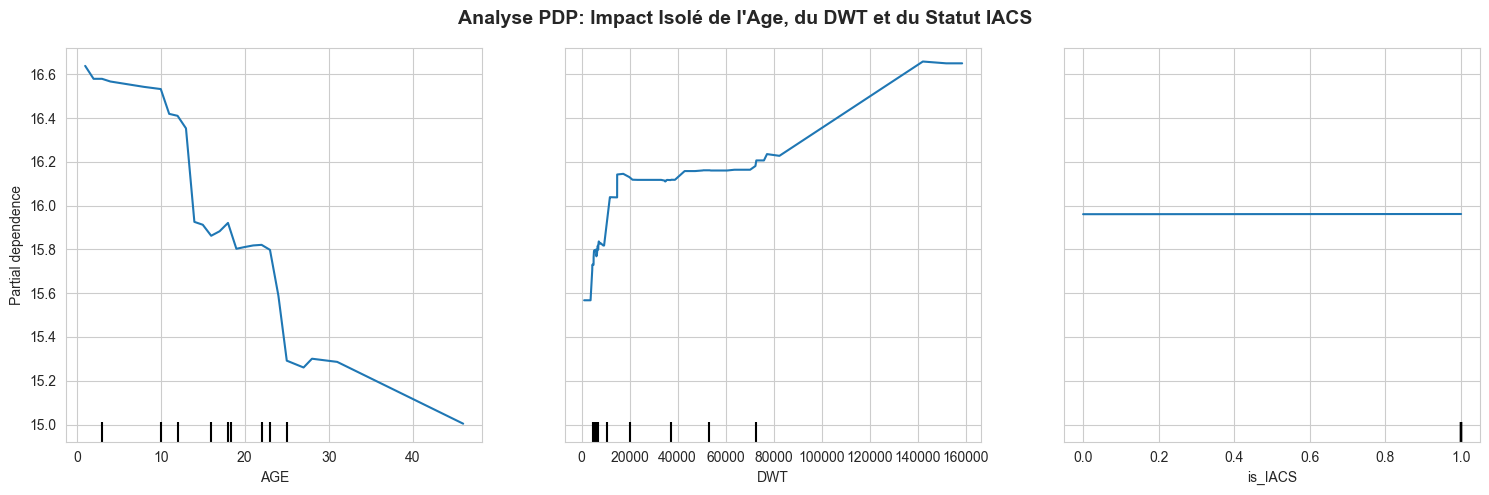

In [65]:
# Partial Dependence Plots
fig, ax = plt.subplots(figsize=(15, 5))
PartialDependenceDisplay.from_estimator(
    model_xgb, 
    X_train, 
    features=[0, 1, 5],  # AGE (index 0), DWT (index 1), is_IACS (index 5)
    feature_names=features,
    ax=ax
)
plt.suptitle('Analyse PDP: Impact Isolé de l\'Age, du DWT et du Statut IACS', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Étape 33 : Test de Prédiction Manuelle
Testez le modèle avec un navire fictif.

In [66]:
# Création d'un navire fictif
# AGE=10, DWT=5000, GRT=2500, Puissance=1200, Type=5, IACS=1, Pays=1
fake_ship = np.array([[10, 5000, 2500, 1200, 5, 1, 1]])
fake_ship_df = pd.DataFrame(fake_ship, columns=features)

# Prédiction
prediction_log = model_xgb.predict(fake_ship_df)
prediction_real = np.expm1(prediction_log)

print("="*50)
print("TEST SUR UN NAVIRE FICTIF")
print("="*50)
print("Caractéristiques du navire:")
print(f"  - Age: 10 ans")
print(f"  - DWT: 5000 tonnes")
print(f"  - GRT: 2500")
print(f"  - Puissance moteur: 1200 kW")
print(f"  - Type: 5")
print(f"  - Membre IACS: Oui")
print(f"  - Pays: 1")
print("-"*50)
print(f"Prix estimé: ${prediction_real[0]:,.2f} USD")
print("="*50)

TEST SUR UN NAVIRE FICTIF
Caractéristiques du navire:
  - Age: 10 ans
  - DWT: 5000 tonnes
  - GRT: 2500
  - Puissance moteur: 1200 kW
  - Type: 5
  - Membre IACS: Oui
  - Pays: 1
--------------------------------------------------
Prix estimé: $11,503,978.00 USD


# Configuration du Random Forest
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1  # Utilise tous les processeurs
)

# Entraînement
rf_model.fit(X_train, y_train)

print('✅ Modèle Random Forest entraîné avec succès!')

# Prédictions
y_pred_rf_log = rf_model.predict(X_test)
y_pred_rf_real = np.expm1(y_pred_rf_log)

# Calcul des métriques
r2_rf = r2_score(y_test, y_pred_rf_log)
mae_rf = mean_absolute_error(y_test_real, y_pred_rf_real)
rmse_rf = np.sqrt(mean_squared_error(y_test_real, y_pred_rf_real))

# Affichage des résultats
print("="*50)
print("RÉSULTATS DU MODÈLE RANDOM FOREST")
print("="*50)
print(f"Coefficient de Détermination (R²): {r2_rf:.4f} ({r2_rf*100:.2f}%)")
print(f"Erreur Absolue Moyenne (MAE): ${mae_rf:,.2f}")
print(f"Erreur Quadratique Moyenne (RMSE): ${rmse_rf:,.2f}")
print("="*50)

# Préparation des données pour comparaison
models = ['XGBoost', 'Random Forest']
r2_scores = [r2_xgb * 100, r2_rf * 100]
mae_values = [mae_xgb, mae_rf]

# Création de la figure avec double axe
fig, ax1 = plt.subplots(figsize=(12, 6))

# Axe pour le R²
color = 'tab:blue'
ax1.set_xlabel('Modèles', fontsize=12)
ax1.set_ylabel('R² Score (%)', color=color, fontsize=12)
bars = ax1.bar(models, r2_scores, color=color, alpha=0.6, width=0.4, label='R² (%)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([0, 100])

# Ajout des valeurs sur les barres
for bar, score in zip(bars, r2_scores):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Axe pour la MAE
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('MAE (USD)', color=color, fontsize=12)
line = ax2.plot(models, mae_values, color=color, marker='o', linewidth=3, markersize=10, label='MAE')
ax2.tick_params(axis='y', labelcolor=color)

# Ajout des valeurs sur la courbe
for i, (model, mae) in enumerate(zip(models, mae_values)):
    ax2.text(i, mae, f'${mae:,.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title('Comparaison des Performances: XGBoost vs Random Forest', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

# Résumé
print("\nRÉSUMÉ DE LA COMPARAISON:")
print("="*60)
print(f"{'Métrique':<20} {'XGBoost':<20} {'Random Forest':<20}")
print("-"*60)
print(f"{'R² Score':<20} {r2_xgb*100:>18.2f}% {r2_rf*100:>18.2f}%")
print(f"{'MAE (USD)':<20} ${mae_xgb:>17,.0f} ${mae_rf:>17,.0f}")
print(f"{'RMSE (USD)':<20} ${rmse_xgb:>17,.0f} ${rmse_rf:>17,.0f}")
print("="*60)
winner = 'XGBoost' if r2_xgb > r2_rf else 'Random Forest'
improvement = abs(r2_xgb - r2_rf) * 100
print(f"\n🏆 Meilleur modèle: {winner}")
print(f"   Amélioration du R²: {improvement:.2f} points")